<a href="https://colab.research.google.com/github/Doritosch/CNN_project/blob/main/Sign_Language_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sign Language Learning

<img src = "https://storage.googleapis.com/kaggle-datasets-images/1589971/2615881/8c75a3a537b7482d949ca4335f2f272e/dataset-cover.jpg?t=2021-09-15-00-21-25">

### kaggle 'WLASL' 데이터 셋 가져오기

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import json
import shutil
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import argparse
import time
import tensorflow.keras.backend as K


### WLASL 단어 정보 확인

In [ ]:
main_path = "/content/"
wlasl_df = pd.read_json(main_path + "WLASL_v0.3.json")

In [ ]:
wlasl_df.head()

gloss                                          instances
0      book  [{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...
1     drink  [{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...
2  computer  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
3    before  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
4     chair  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...

In [ ]:
wlasl_df.shape

(2000, 2)

### Extract the available video

In [ ]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance

    input: instance json list
    output: list of videos_ids

    """
    videos_list = []
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list

In [ ]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance

    input: instance json list
    output: list of videos_ids

    """
    videos_ids = []
    videos_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
    return videos_ids, videos_urls

In [ ]:
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)

In [ ]:
get_videos_ids(instance_json[0]['instances'])[0]

'69241'

In [ ]:
wlasl_df['videos_ids'] = wlasl_df['instances'].apply(get_videos_ids)

In [ ]:
features_df = pd.DataFrame(columns=['gloss', 'video_id', 'url'])
for row in wlasl_df.iterrows():
#     print(row[1][1])
    ids, urls = get_json_features(row[1][1])
    word = [row[1][0]] * len(ids)
    df = pd.DataFrame(list(zip(word, ids, urls)), columns = features_df.columns)
    features_df = features_df.append(df, ignore_index=True)

<ipython-input-12-c77222b2c282>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df = features_df.append(df, ignore_index=True)


In [ ]:
features_df.index.name = 'index'
features_df

gloss video_id                                                url
index                                                                        
0            book    69241       http://aslbricks.org/New/ASL-Videos/book.mp4
1            book    07069  https://signstock.blob.core.windows.net/signsc...
2            book    07068  https://s3-us-west-1.amazonaws.com/files.start...
3            book    07070  https://media.asldeafined.com/vocabulary/14666...
4            book    07099     http://www.aslsearch.com/signs/videos/book.mp4
...           ...      ...                                                ...
11975  wheelchair    63047  https://www.signingsavvy.com/signs/mp4/5/5233.mp4
11976  wheelchair    63050  http://www.aslsearch.com/signs/videos/wheelcha...
11977     whistle    63186  https://media.spreadthesign.com/video/mp4/13/9...
11978     whistle    63188  https://www.signingsavvy.com/signs/mp4/9/9961.mp4
11979     whistle    63190  http://www.aslsearch.com/signs/videos/whistle.mp4

[11980 rows x 3 columns]

In [ ]:
features_df.to_csv('features_df.csv', index=False)

In [ ]:
wlasl_df.head()

gloss                                          instances  \
0      book  [{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...   
1     drink  [{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...   
2  computer  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...   
3    before  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...   
4     chair  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...   

                                          videos_ids  
0         [69241, 07069, 07068, 07070, 07099, 07074]  
1  [69302, 65539, 17710, 17733, 65540, 17734, 177...  
2  [12328, 12312, 12311, 12338, 12313, 12314, 123...  
3  [05728, 05749, 05750, 05729, 05730, 65167, 057...  
4  [09848, 09869, 09849, 09850, 09851, 65328, 09854]

In [ ]:
word_count = wlasl_df['gloss'].count()

print("단어 개수:", word_count)

단어 개수: 2000


### 데이터 프레임을 사용해 word_folders 폴더에 각 단어 폴더 생성 후 옮겨주기

In [ ]:
# 데이터프레임에서 비디오 파일을 폴더로 이동
for idx, row in wlasl_df.iterrows():
    word = row['gloss']  # 단어
    video_ids = row['videos_ids']  # 비디오 ID 리스트

    # 단어 폴더 생성
    word_dir = os.path.join(main_path, 'word_folders', word)
    os.makedirs(word_dir, exist_ok=True)

    # 각 비디오 파일을 단어 폴더로 이동
    for video_id in video_ids:
        video_path = os.path.join(main_path, 'videos', f'{video_id}.mp4')  # 비디오 파일 경로
        destination_path = os.path.join(word_dir, f'{video_id}.mp4')  # 이동할 경로
        shutil.move(video_path, destination_path)

# 작업 완료 메시지 출력
print("단어 폴더에 비디오 파일 이동이 완료되었습니다.")


단어 폴더에 비디오 파일 이동이 완료되었습니다.


In [ ]:
data_folder = '/content/word_folders'

# 폴더 목록 가져오기
word_folders = os.listdir(data_folder)

files = []  # 파일 이름을 저장할 리스트
labels = []  # 레이블을 저장할 리스트

for word_folder in word_folders:
    # 단어 폴더 경로 생성
    word_folder_path = os.path.join(data_folder, word_folder)

    # 폴더 내 파일 목록 가져오기
    word_files = os.listdir(word_folder_path)

    for file in word_files:
        # 파일 경로 생성
        file_path = os.path.join(word_folder_path, file)

        # 파일 이름과 레이블 추가
        files.append(file_path)
        labels.append(word_folder)


In [ ]:
root_video_folder = '/content/word_folders/'
keep_files = 2

for word_folder in os.listdir(root_video_folder):
    # 각 단어별 폴더 경로
    word_videos_path = os.path.join(root_video_folder, word_folder)

    # 단어별 폴더 내의 모든 파일 리스트
    all_files = os.listdir(word_videos_path)

    # 파일이 2개를 초과할 때만 처리
    if len(all_files) > keep_files:
        # 파일 리스트를 정렬하고 상위 2개 제외한 나머 파일 삭제
        all_files.sort()
        files_to_remove = all_files[keep_files:]

        for file_name in files_to_remove:
            file_path = os.path.join(word_videos_path, file_name)
            os.remove(file_path)
            print(f"Deleted: {file_path}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Deleted: /content/word_folders/october/39364.mp4
Deleted: /content/word_folders/october/39368.mp4
Deleted: /content/word_folders/think/57975.mp4
Deleted: /content/word_folders/think/57977.mp4
Deleted: /content/word_folders/think/57982.mp4
Deleted: /content/word_folders/think/66609.mp4
Deleted: /content/word_folders/think/69505.mp4
Deleted: /content/word_folders/institute/29982.mp4
Deleted: /content/word_folders/institute/29986.mp4
Deleted: /content/word_folders/institute/65947.mp4
Deleted: /content/word_folders/place/42989.mp4
Deleted: /content/word_folders/place/42994.mp4
Deleted: /content/word_folders/place/69432.mp4
Deleted: /content/word_folders/precipitation/44178.mp4
Deleted: /content/word_folders/precipitation/44179.mp4
Deleted: /content/word_folders/precipitation/44180.mp4
Deleted: /content/word_folders/precipitation/44182.mp4
Deleted: /content/word_folders/whatever/62955.mp4
Deleted: /content/word_folders/whatever/66772.mp4
Deleted: /content

### 비디오 -> 이미지

In [ ]:
def video_to_frames(video_path, save_path, num_frames=25):
    vid = cv2.VideoCapture(video_path)

    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_step = max(total_frames // num_frames,1)

    for i in range(0, total_frames, frames_step):
        vid.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = vid.read()

        if ret:  # 프레임을 읽었는지 확인
            file_name = os.path.join(save_path, f"frame_{i}.png")
            cv2.imwrite(file_name, frame)

    vid.release()


In [ ]:
word_folders = '/content/word_folders/'
frame_save_folder = '/content/frame_images/'

if not os.path.exists(frame_save_folder):
    os.makedirs(frame_save_folder)

for word_folder in os.listdir(word_folders):
    word_videos_path = os.path.join(word_folders, word_folder)
    word_frames_path = os.path.join(frame_save_folder, word_folder)

    if not os.path.exists(word_frames_path):
        os.makedirs(word_frames_path)

    for video in os.listdir(word_videos_path):
        video_path = os.path.join(word_videos_path, video)
        save_path = os.path.join(word_frames_path, os.path.splitext(video)[0])

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        video_to_frames(video_path, save_path)

### 프레임화한 이미지 출력

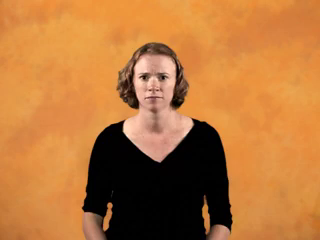

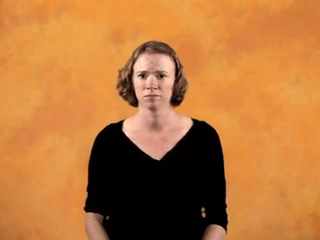

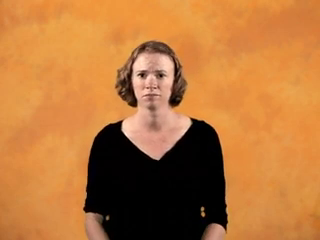

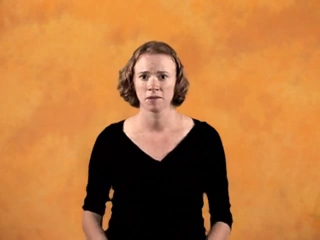

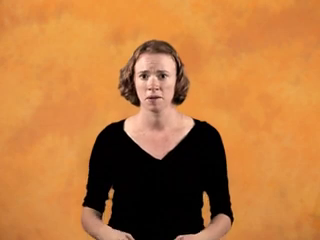

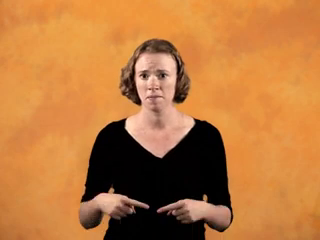

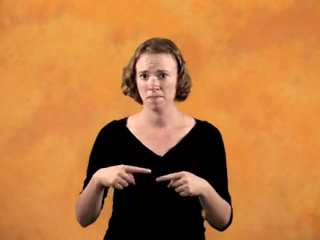

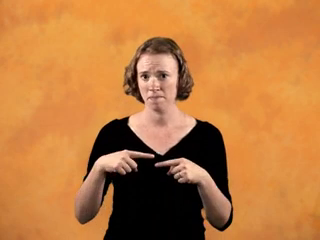

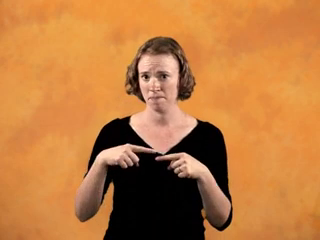

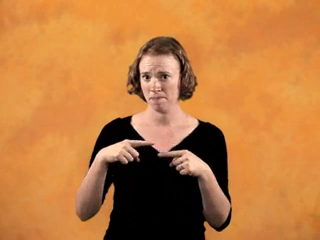

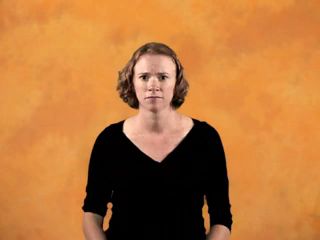

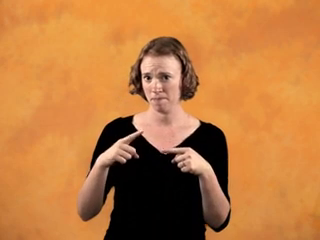

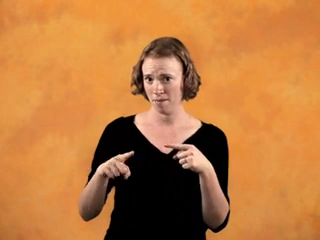

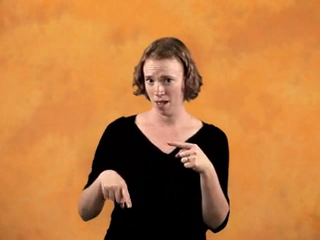

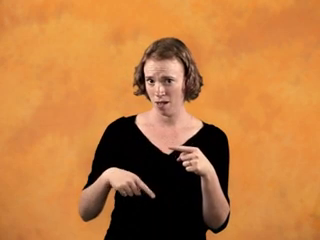

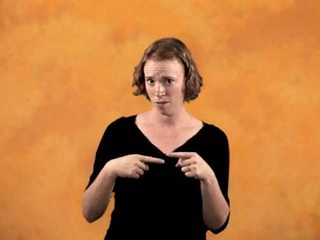

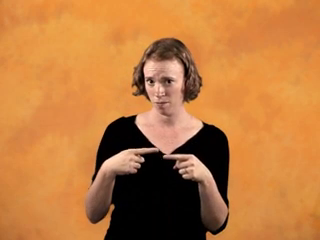

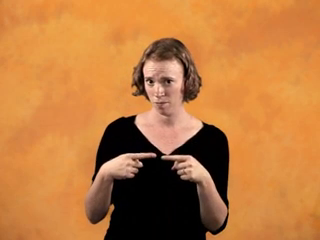

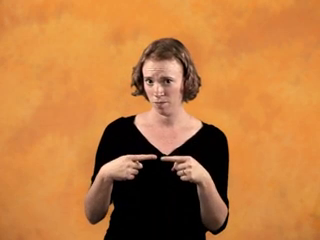

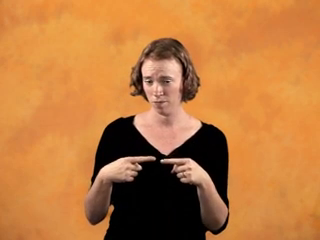

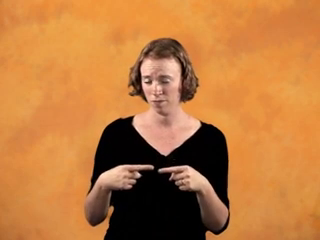

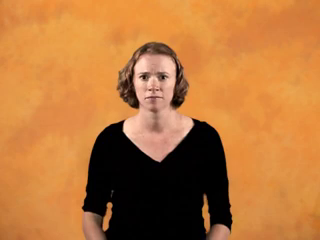

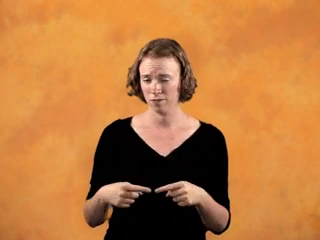

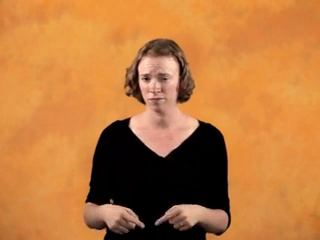

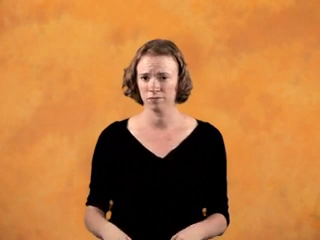

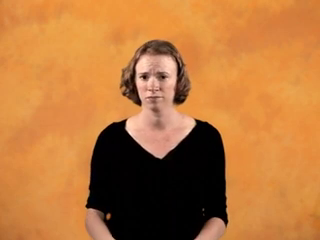

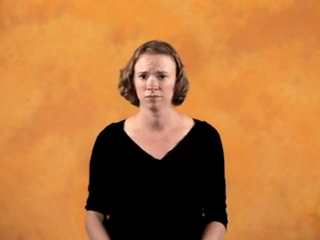

In [ ]:
# 이미지 파일 경로 설정
img_folder_path = '/content/frame_images/about/00414/'

# 이미지 파일 리스트 조회
img_files = sorted([f for f in os.listdir(img_folder_path) if f.endswith('.png')])

# 각 이미지 파일을 읽어 화면에 출력
for img_file in img_files:
    img_path = os.path.join(img_folder_path, img_file)
    img = cv2.imread(img_path)
    cv2_imshow(img)
    cv2.waitKey(0)

cv2.destroyAllWindows()

### VGG16 model -> 이미지의 특징 벡터 추출

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

vgg16_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
def get_vgg_features(images):
    preprocessed_images = preprocess_input(images)
    features = vgg16_model.predict(preprocessed_images)
    return features

In [ ]:
import cv2

all_videos_features = []

for word in os.listdir(frame_save_folder):
    word_frames_path = os.path.join(frame_save_folder, word_folder)

    for frame_folder in os.listdir(word_frames_path):
        frame_folder_path = os.path.join(word_frames_path, frame_folder)

        frames_images = []
        for frame in sorted(glob.glob(frame_folder_path + '/*.png')):
            img = cv2.imread(frame)
            img = cv2.resize(img, (224, 224))
            frames_images.append(img)
        if frames_images:
            video_features = get_vgg_features(np.array(frames_images))


        # LSTM에 입력할 수 있도록 특징 벡터의 차원을 변경
            lstm_input = np.reshape(video_features, (-1, video_features.shape[-1]))

            all_videos_features.append(lstm_input)


1/1 [==============================] - 0s 29ms/step


In [ ]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = np.resize(img, (224, 224, 3))  # numpy.resize 함수를 사용하여 이미지 크기를 조정
        img_array = image.img_to_array(img_resized)
        processed_images.append(preprocess_input(img_array))
    return processed_images

### LSTM -> 시계열 데이터 처리

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

lstm_input = np.reshape(video_features, (-1, video_features.shape[-1]))
# 길이가 가변적일 수 있으므로 None 값을 사용합니다.
input_shape = (None, lstm_input.shape[-1])

num_classes = 2000
model = Sequential()
model.add(LSTM(256, input_shape=input_shape))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_videos_features, labels, test_size=0.2, stratify=labels, random_state=42)

ValueError: ignored

In [ ]:
model = Sequential([
    LSTM(128, input_shape=frame_features.shape[1:], return_sequences=True), # input_shape = (timesteps, input_dim)
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(frame_features,
                    epochs=10,
                    validation_split=0.2)


## 결과 ( VGG16, LSTM 추가 전 )

In [ ]:
def video_to_frames(video_path, save_path, num_frames=25):
    vid = cv2.VideoCapture(video_path)

    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_step = max(total_frames // num_frames,1)

    for i in range(0, total_frames, frames_step):
        vid.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = vid.read()

        if ret:  # check if the frame was successfully read
            file_name = os.path.join(save_path, f"frame_{i}.png")
            cv2.imwrite(file_name, frame)

    vid.release()

In [ ]:
word_folders = '/content/word_folders/'
frame_save_folder = '/content/frame_images/'

if not os.path.exists(frame_save_folder):
    os.makedirs(frame_save_folder)

for word_folder in os.listdir(word_folders):
    word_videos_path = os.path.join(word_folders, word_folder)
    word_frames_path = os.path.join(frame_save_folder, word_folder)

    if not os.path.exists(word_frames_path):
        os.makedirs(word_frames_path)

    for video in os.listdir(word_videos_path):
        video_path = os.path.join(word_videos_path, video)
        save_path = os.path.join(word_frames_path, os.path.splitext(video)[0])

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        video_to_frames(video_path, save_path)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
img_size = (128, 128)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    frame_save_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    frame_save_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

In [ ]:
num_classes = len(os.listdir(word_folders))

model = Sequential([
Conv2D(32, (3, 3), activation='relu', input_shape=(*img_size, 3)),
MaxPooling2D(pool_size=(2, 2)),
Conv2D(64, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(train_generator,
epochs=10,
validation_data=validation_generator)

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

358/358 [==============================] - 76s 211ms/step - loss: 0.5745 - accuracy: 0.8287
Test loss: 0.5745, Test accuracy: 0.8287


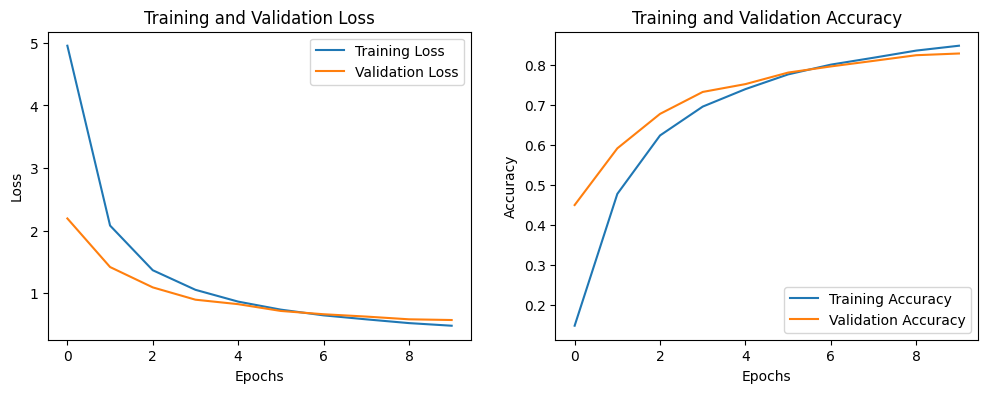

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def preprocess_frames_from_video(video_path, img_size):
    cap = cv2.VideoCapture(video_path)
    frame_list = []

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # OpenCV로 읽은 이미지를 RGB 형식으로 변환합니다.
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 이미지를 리사이징합니다.
        frame = cv2.resize(frame, img_size)

        # 이미지를 [0, 1] 범위로 정규화합니다.
        frame = frame / 255.0

        frame_list.append(frame)

    cap.release()

    return np.array(frame_list)
# lay 단어의 수화 동영상 input
video_path = '/content/word_folders/lazy/32510.mp4'
img_size = (128, 128)  # 모델에 맞는 입력 이미지 크기
frame_images = preprocess_frames_from_video(video_path, img_size)
predictions = model.predict(frame_images)


3/3 [==============================] - 0s 78ms/step


In [ ]:
print(predictions)

[[4.9220277e-11 2.1900248e-09 2.8141373e-11 ... 6.8533991e-11
  4.2402014e-13 1.6911535e-11]
 [6.3508539e-11 1.7882563e-09 1.2649027e-11 ... 4.0692078e-11
  2.9112368e-13 9.3462538e-12]
 [1.5306099e-10 1.9976869e-09 1.0013446e-11 ... 1.6809042e-11
  1.2061818e-13 1.8100659e-12]
 ...
 [6.9928459e-11 3.0816611e-09 3.5312367e-12 ... 3.2294961e-10
  1.6965875e-10 3.7390192e-11]
 [3.9967751e-11 1.2502497e-09 4.2881488e-12 ... 1.4097343e-09
  5.4347193e-10 8.7307092e-11]
 [2.0006391e-11 5.0287446e-10 6.5111987e-12 ... 6.0257896e-09
  9.2697644e-10 3.3097530e-10]]


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[ 998  998 1003  999  999  999  999  999  999  999  994  994  999  999
  999  999  999  999  999  999  999  999  999  999  999  999  999  999
  999  999  999  999  999  999  999  999  999  999  999  999  999  999
  999  999  999  999  999  999  999  999  999  999  999  999  999  999
  999  999  999  999  999  999  999  999  999  999  999  999  999  999
  999  999  999  999  999  999  999  999  999  999  999  998  998  999]


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels = [labels[predicted_class] for predicted_class in predicted_classes]
print(predicted_labels)

['ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready']


In [ ]:
counter = Counter(predicted_labels)
most_common_label = counter.most_common(1)[0][0]
print(most_common_label)

ready


## 개선해야할 부분

#### **onepose기술을 사용해서 좌표값을 사용하자**

graph_opt.pb file download <br>
<b>
https://github.com/quanhua92/human-pose-estimation-opencv/blob/master/graph_opt.pb

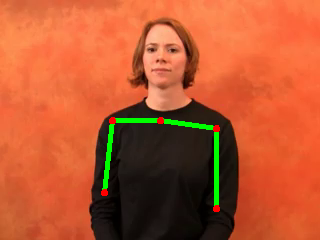

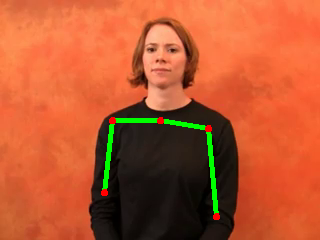

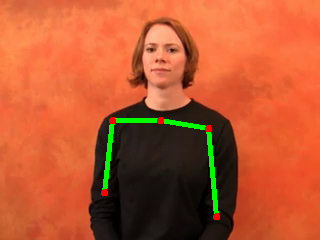

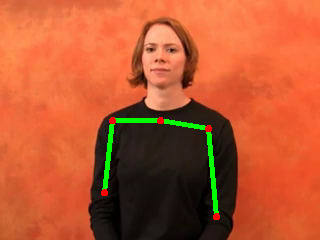

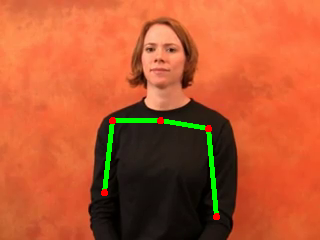

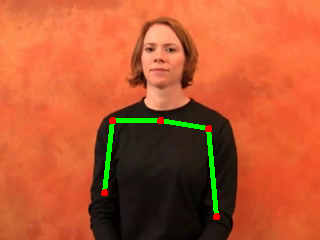

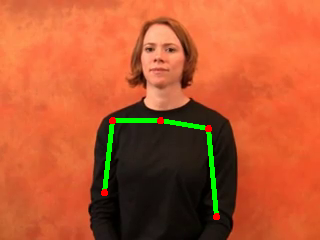

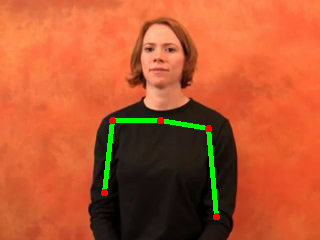

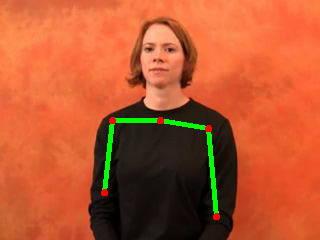

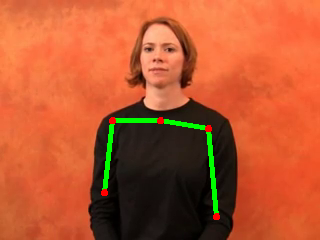

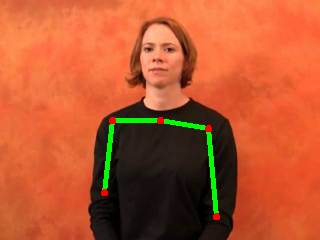

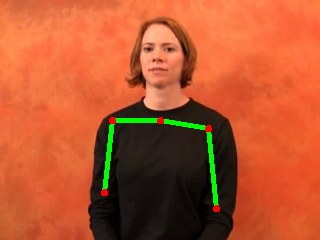

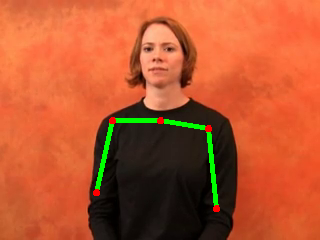

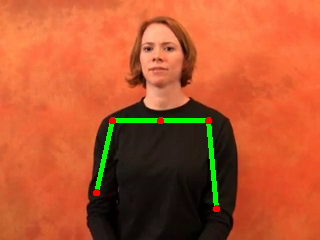

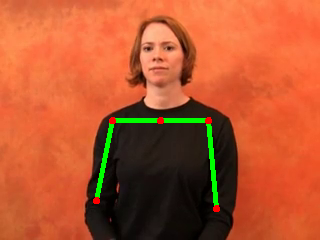

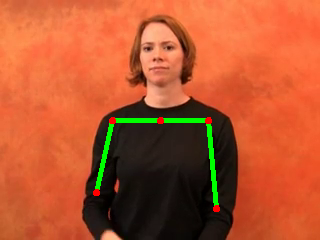

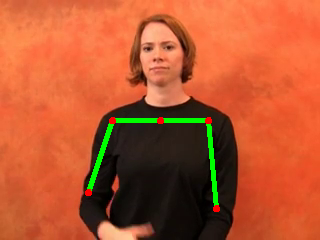

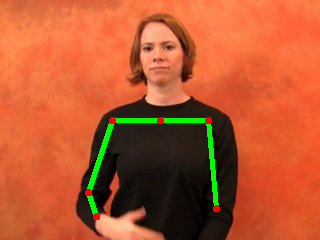

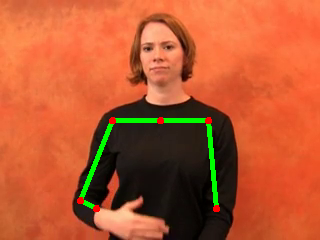

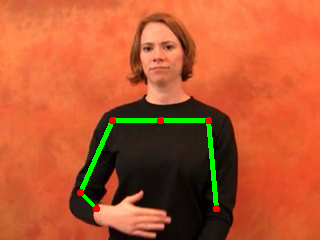

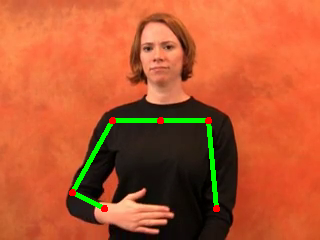

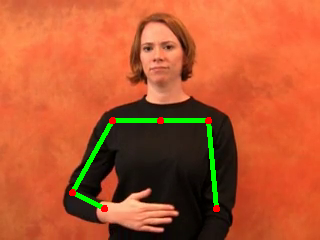

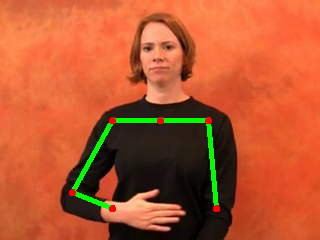

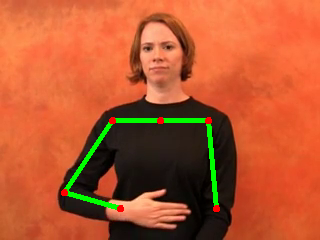

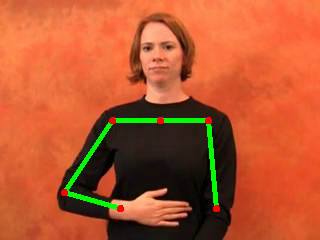

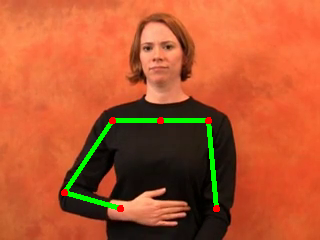

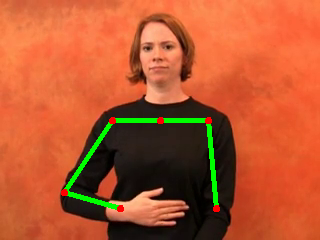

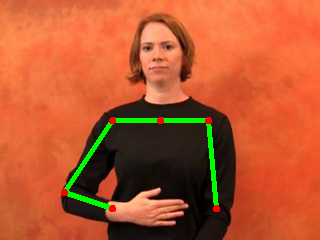

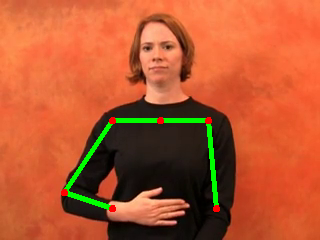

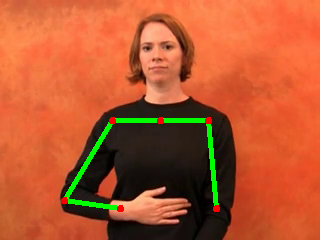

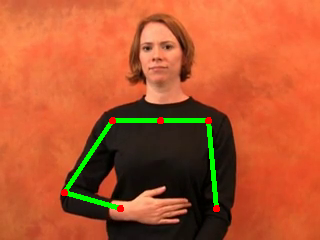

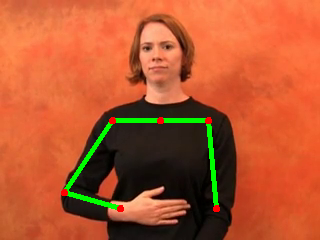

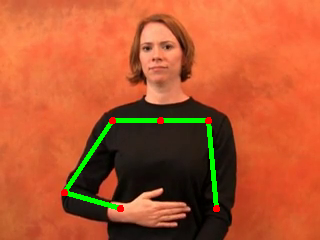

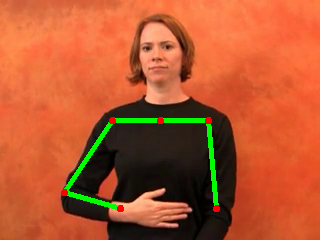

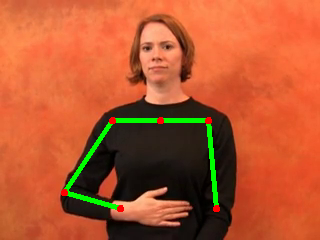

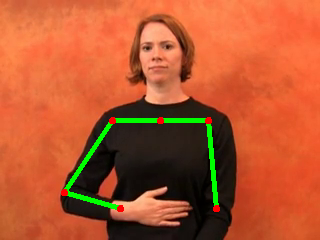

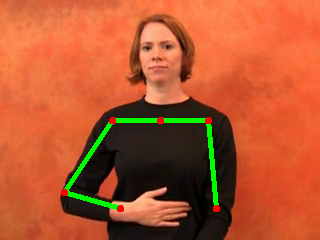

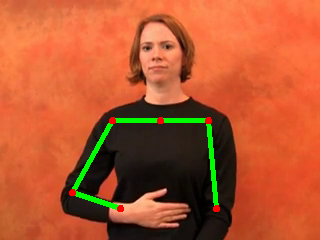

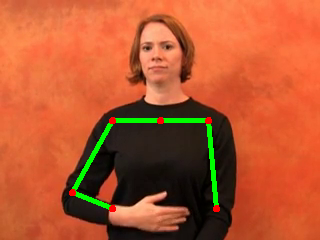

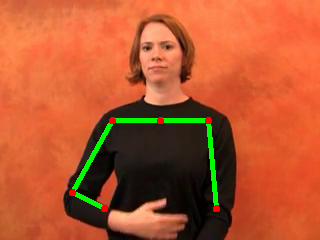

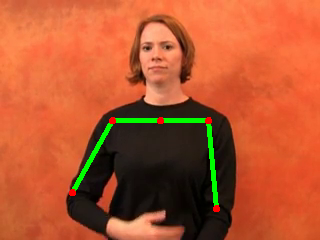

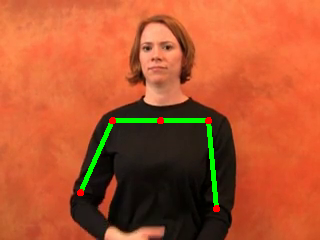

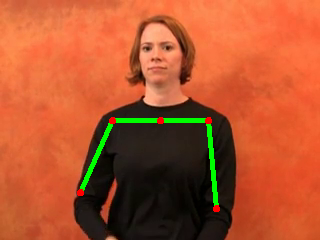

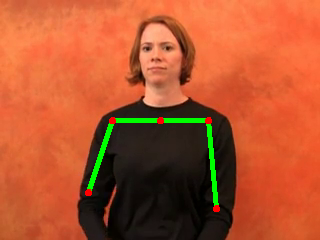

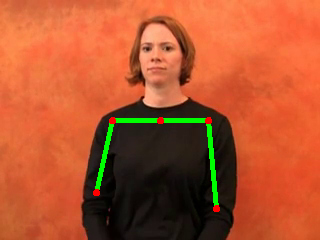

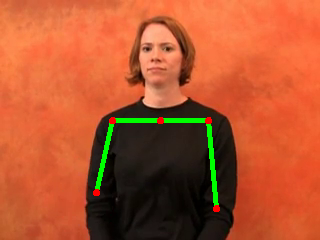

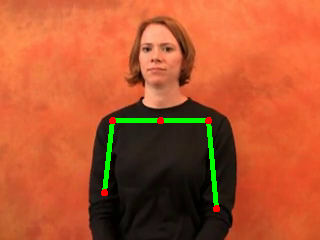

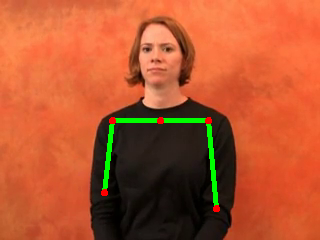

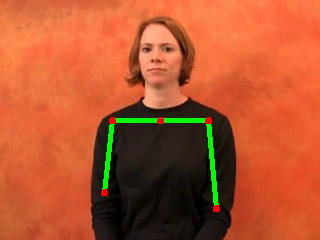

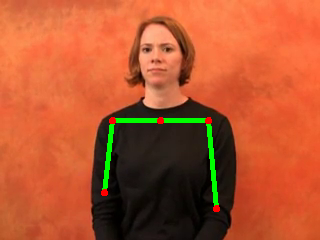

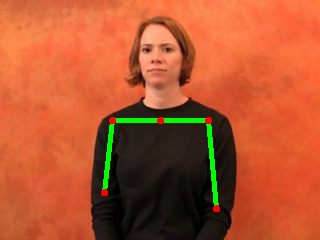

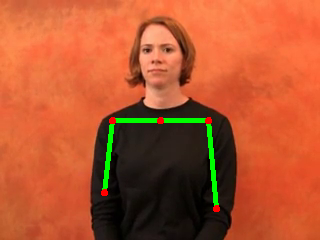

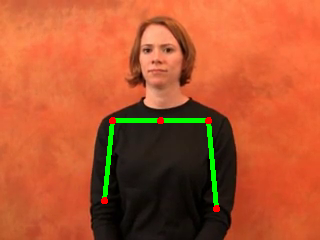

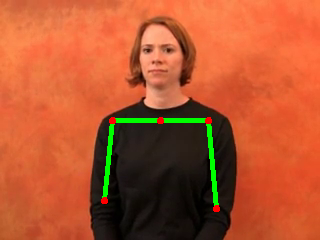

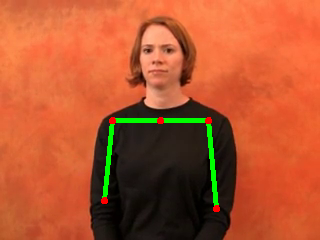

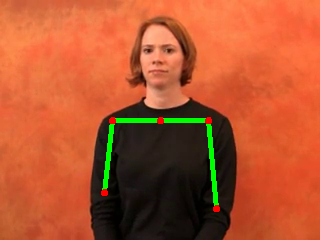

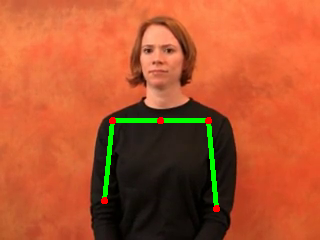

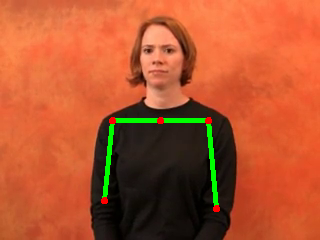

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('/content/word_folders/abdomen/00335.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee" :12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [("Neck", "RShoulder"), ("Neck", "LShoulder"), ("RShoulder", "RElbow"),
              ("RElbow", "RWrist"), ("LShoulder", "LElbow"), ("LElbow", "LWrist"),
              ("Neck", "RHip"), ("RHip", "RKnee"), ("RKnee", "RAnkle"), ("Neck", "LHip"),
              ("LHip", "LKnee"), ("LKnee", "LAnkle")] # 얼굴 관련 쌍이 제거됨




# Load the human pose neural network
net = cv2.dnn.readNetFromTensorflow("/content/graph_opt.pb")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Prepare the input to the network
    inp = cv2.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, .5), swapRB=True, crop=False)
    net.setInput(inp)

    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet outputs 57 channels, but we only need the first 19 for pose detection.

    # Process keypoints
    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (width * point[0]) // out.shape[3]
        y = (height * point[1]) // out.shape[2]
        points.append((int(x), int(y)) if conf > 0.2 else None)

    # Draw the connections
    for pair in POSE_PAIRS:
        partFrom, partTo = pair
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo],(0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    cv2_imshow(frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
